# PHYS 3317 -- Using Finite Differences to find Eigenstates of 1D single particle Hamiltonians

Please hand in this completed notebook before next Friday.

<font color="red"><em> Vineet Kamat </em></font>

Here we will use computational Linear Algebra to solve the time independent Schrodinger Equation

## Constructing the Hamiltonian

This section constructs the Hamiltonian as a matrix.  You have seen this before.

In [49]:
# Hit shift-enter 
%pylab inline

from scipy.sparse import *  # loads the functions to deal with sparse matrices
from showmat import showmat # loads display functions 
# if you get an error message, download showmat.py and put in directory with notebooks

Populating the interactive namespace from numpy and matplotlib


/Users/vineetkamat/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['hstack', 'vstack', 'eye', 'kron', 'rand', 'extract', 'random', 'find', 'tril', 'identity', 'grid', 'triu', 'bmat']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


First we make a function which generates the finite difference approximation to the second derivative.  

In [50]:
# you don't need to do anything here -- just hit shift-enter
def SecondDerivMatrix(numpoints,dx,periodic) : 
    """SecondDerivMatrix(numpoints,dx,periodic) returns a sparse matrix
    which represents the second derivative -- using a 3-point derivative.  

    It takes periodic needed arguments:
    numpoints -- an integer which is how many points are in the grid
    dx -- the real space lattice spacing
    periodic -- do we use periodic boundary conditions?

    Setting periodic to "False" will give "hard wall boundaries"
    """
    unitlist=ones(numpoints)  # just a list of 1's whose length is equal to the length of the grid
    if periodic :
        return dia_matrix(       # we are generating a sparse matrix by specifying the diagonals
            ((unitlist/(dx**2),unitlist/(dx**2),-2*unitlist/(dx**2),unitlist/(dx**2),unitlist/(dx**2)),
            (1,-1,0,numpoints-1,1-numpoints)),  # this line specifies which the diagonals
            shape=(numpoints,numpoints))
    else :
        return dia_matrix(       # we are generating a sparse matrix by specifying the diagonals
            ((unitlist/(dx**2),unitlist/(dx**2),-2*unitlist/(dx**2)),
            (1,-1,0)),  # this line specifies which the diagonals
            shape=(numpoints,numpoints))

To make this concrete lets generate examples

In [51]:
sm=SecondDerivMatrix(numpoints=9,dx=0.5,periodic=False) #make an example

In [52]:
showmat(sm.todense()) # look at it

-8,4,,,,,,,
4,-8,4,,,,,,
,4,-8,4,,,,,
,,4,-8,4,,,,
,,,4,-8,4,,,
,,,,4,-8,4,,
,,,,,4,-8,4,
,,,,,,4,-8,4
,,,,,,,4,-8


Here is the same thing, but with periodic boundary conditions

In [53]:
sm2=SecondDerivMatrix(numpoints=9,dx=0.5,periodic=True) #make an example

In [54]:
showmat(sm2.todense()) # look at it

-8,4,,,,,,,4
4,-8,4,,,,,,
,4,-8,4,,,,,
,,4,-8,4,,,,
,,,4,-8,4,,,
,,,,4,-8,4,,
,,,,,4,-8,4,
,,,,,,4,-8,4
4,,,,,,,4,-8


Next we make a function which generates the finite difference approximation to the operator V(x).  This is a diagonal matrix:

$$
\left(
\begin{array}{ccccc}
V(x_1)&0&\cdots&&\cr
0&V(x_2)&0&0&\cdots\cr
0&0&V(x_3)&0&\cdots\cr
\vdots\cr
\vdots&&&&V(x_n)
\end{array}
\right)
\left(
\begin{array}{c}
\psi(x_1)\cr
\psi(x_2)\cr
\psi(x_3)\cr
\vdots\cr
\psi(x_n)
\end{array}
\right)=
\left(
\begin{array}{c}
V(x_1)\psi(x_1)\cr
V(x_2)\psi(x_2)\cr
V(x_3)\psi(x_3)\cr
\vdots\cr
V(x_n)\psi(x_n)
\end{array}\right)
$$


For variety, this time instead of taking a list of V's as its argument, I will make it so it takes the function $V(x)$ as its argument

In [55]:
# Hit shift-enter

def PotentialMatrix(potentialfunction,minx,maxx,numpoints=None,dx=None):
    """PotentialMatrix(potentialfunction,minx,maxx,periodic,numpoints,dx)
    generates a finite difference approximation to the operator V(x).
    It is called by the following arguments:
    potentialfunction -- a function which when called with x returns V(x)
    minx -- smallest x in grid
    maxx -- largest x in grid
    numpoints -- number of points in grid
    dx -- grid spacing

    Either specify numpoints or dx -- but not both"""
    
    # First we check to see if numpoints and/or dx are specified
    #
    # #If you are new to programming, don't worry too much about
    # #this section -- it is just here to give us the flexibility
    # #to specify the grid either by the number of points or
    # #the spacing.  
    #
    # in the former case we would use linspace(xmin,xmax,numpoints)
    # in the latter case we would use arange(xmin,xmax,dx)
    #
    # It is useful to see this sort of construction, as undoubtedly
    # you will want to throw error messages some time in the future.
    #
    if numpoints==None: #was numpoints specified
        if dx==None: #was dx specified
            # oops -- neither are specified, give error message
            raise Exception("Error: you must specify either numpoints or dx")
        else: # great -- dx is specified, but numpoints is not
            grid = arange(minx,maxx+dx,dx)
    else : # numpoints is specified
        if dx==None: # check to make sure dx is not specified
            grid=linspace(minx,maxx,numpoints)
        else : # both are specified
            if dx*(numpoints-1)==(maxx-minx): # are they consistent?
                grid=linspace(minx,maxx,numpoints) 
            else:
                raise Exception("error: dx and numpoints are not consistent -- please just specify one of them")
    
    # now generate the values of the potential on the grid
    potvals=array([potentialfunction(x) for x in grid])
    
    #now generate matrix
    ln=len(grid)
    return dia_matrix((potvals,0),shape=(ln,ln))
    

Next, we want an example potential matrix -- lets use a harmonic oscillator

In [56]:
def hopot(x):  # this is the V(x) for a harmonic oscillator with omega=1,and m=1
    return (x**2)/2.

In [57]:
pm=PotentialMatrix(potentialfunction=hopot,minx=-2,maxx=2,dx=0.5) #make an example

In [58]:
showmat(pm.todense()) #look at it

2,,,,,,,,
,1.12,,,,,,,
,,0.5,,,,,,
,,,0.12,,,,,
,,,,,,,,
,,,,,0.12,,,
,,,,,,0.5,,
,,,,,,,1.12,
,,,,,,,,2


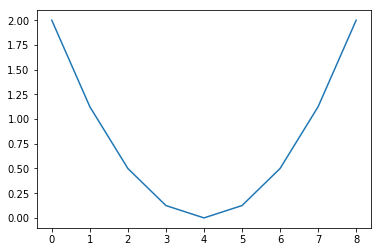

In [59]:
plot(pm.diagonal()) # plot the diagonal

Now lets make a function which generates the Hamiltonian as a matrix

In [60]:
def HamiltonianMatrix(potentialfunction,minx,maxx,numpoints,periodic,hbar=1,mass=1):
    """HamiltonianMatrix(potentialfunction,minx,maxx,numpoints,hbar=1,mass=1)
    generates a finite difference approximation to the hamiltonian operator H
    for the case of a single particle in a potential V(x)

    It is called by the following required arguments:
    potentialfunction -- a function which when called with x returns V(x)
    minx -- smallest x in grid
    maxx -- largest x in grid
    numpoints -- number of points in grid
    
    It also has two optional arguments, which are assumed to be equal to unity if they
    are not specified
    hbar -- Planck's constant divided by 2 pi
    mass -- the particle mass
    """
    dx=1.*(maxx-minx)/(numpoints-1) # calculate grid spacing
    kin=-(0.5*hbar**2/mass)*SecondDerivMatrix(numpoints=numpoints,dx=dx,periodic=periodic) # calculate kinetic energy operator
    pot=PotentialMatrix(potentialfunction=potentialfunction,minx=minx,maxx=maxx,numpoints=numpoints) #calculate potential energy operator
    return kin+pot

Continuing with the harmonic oscilator example

In [61]:
ham1=HamiltonianMatrix(potentialfunction=hopot,minx=-10,maxx=10,numpoints=1000,periodic=True)

In [62]:
ham1.shape # how big is the matrix?

(1000, 1000)

Lets look at the first few entries

In [63]:
showmat(ham1[:10,:10].todense())

$2.5\cdot10^{3}$,$-1.2\cdot10^{3}$,,,,,,,,
$-1.2\cdot10^{3}$,$2.5\cdot10^{3}$,$-1.2\cdot10^{3}$,,,,,,,
,$-1.2\cdot10^{3}$,$2.5\cdot10^{3}$,$-1.2\cdot10^{3}$,,,,,,
,,$-1.2\cdot10^{3}$,$2.5\cdot10^{3}$,$-1.2\cdot10^{3}$,,,,,
,,,$-1.2\cdot10^{3}$,$2.5\cdot10^{3}$,$-1.2\cdot10^{3}$,,,,
,,,,$-1.2\cdot10^{3}$,$2.5\cdot10^{3}$,$-1.2\cdot10^{3}$,,,
,,,,,$-1.2\cdot10^{3}$,$2.5\cdot10^{3}$,$-1.2\cdot10^{3}$,,
,,,,,,$-1.2\cdot10^{3}$,$2.5\cdot10^{3}$,$-1.2\cdot10^{3}$,
,,,,,,,$-1.2\cdot10^{3}$,$2.5\cdot10^{3}$,$-1.2\cdot10^{3}$
,,,,,,,,$-1.2\cdot10^{3}$,$2.5\cdot10^{3}$


Lets look at the last few entries of the first line

In [64]:
showmat(ham1[:10,-10:].todense())

,,,,,,,,,$-1.2\cdot10^{3}$
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,


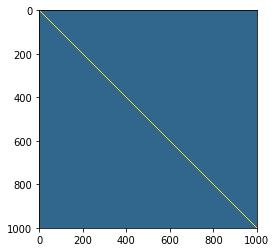

In [65]:
imshow(ham1.todense()) # interpret the entries in the hamiltonian as pixels in an image

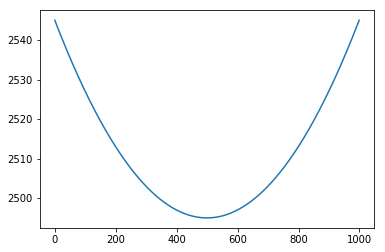

In [66]:
plot(ham1.diagonal()) #plot the diagonal

In [67]:
ham1[0,1] # look at the second element on the first line

-1247.50125

## Numerically finding the eigenvalues and eigenvectors

In [68]:
from scipy.sparse.linalg import eigsh  # load the function which calculates eigenvectors of hermitian matrices

In [69]:
?eigsh

Here is an example of just getting the eigenvalues

In [70]:
eigsh(ham1, # matrix to diagonalize
 k=10, # find 10 eigenvalues
 sigma=0, # find eigenvalues closest to 0
 return_eigenvectors=False # just give eigenvalues
 )

array([0.49998747, 1.49993737, 2.49983716, 3.49968685, 4.49948641,
       5.49923587, 6.4989352 , 7.4985844 , 8.49818348, 9.49773243])

Take a moment to marvel in this -- you just diagonalized a 1000x1000 matrix.

Here is how we get both eigenvalues and eigenvectors

In [71]:
energies,wavefunctions=eigsh(ham1,k=10, sigma=0,  return_eigenvectors=True)

Lets now plot the lowest few eigenvectors -- note these wavefunctions are not normalized.

In [72]:
grid=linspace(-10,10,1000)

Text(0,0.5,'$\\psi$ [Arbitrary Units]')

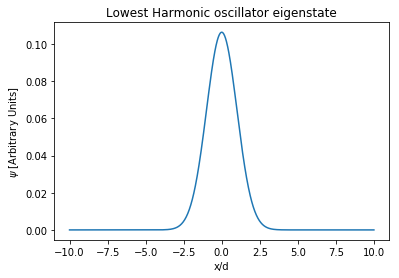

In [73]:
plot(grid,-wavefunctions[:,0])
title("Lowest Harmonic oscillator eigenstate")
xlabel("x/d")
ylabel("$\psi$ [Arbitrary Units]")

Text(0,0.5,'$\\psi$ [Arbitrary Units]')

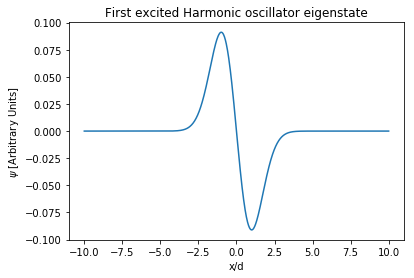

In [74]:
plot(grid,-wavefunctions[:,1])
title("First excited Harmonic oscillator eigenstate")
xlabel("x/d")
ylabel("$\psi$ [Arbitrary Units]")

Text(0,0.5,'$\\psi$ [Arbitrary Units]')

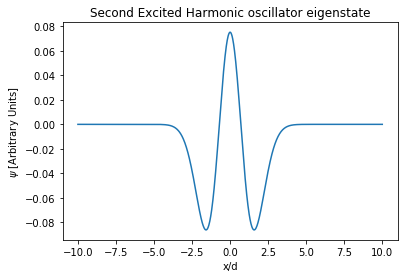

In [75]:
plot(grid,-wavefunctions[:,2])
title("Second Excited Harmonic oscillator eigenstate")
xlabel("x/d")
ylabel("$\psi$ [Arbitrary Units]")

Lets now make a classic picture which you might have seen in a textbook.  We will plot each of the wavefunctions, offsetting them by the energy

In [76]:
potvalues= 0.5*grid**2

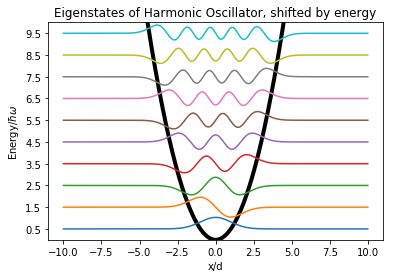

In [77]:
plot(grid,potvalues,linewidth=4,color=(0,0,0)) #plot the parabola representing the harmonic potential 
ylim(0,10) # rescale the y-axis
xlabel("x/d") # label the x-axis
ylabel("Energy/$\hbar\omega$") # label the y-axis
title("Eigenstates of Harmonic Oscillator, shifted by energy") # set title
yticks(arange(0.5,10,1)) # set the ticks on the y-axis to line up with the energies of the states
for index,en in enumerate(energies): # loop over the eigen-energies
    plot(grid,en-5*wavefunctions[:,index]) # plot each wavefunction, scaling and offsetting

### Problems

1) Numerically calculate the lowest 5 eigen-energies of an infinite square well of length 1, in units where hbar=m=1.  

Note: you don't need to use HamiltonianMatrix -- just use SecondDerivMatrix with hard wall boundaries.  Plot the eigenstates. (The plot doesn't need to be as fancy as the last one we did for the Harmonic Oscillator -- just separate graphs are fine.  Label the axes.  If you want to make the fancy graphs, that is also fine.)

<u>Give answer (program) here -- add more cells as neccessary </u>

In [95]:
n = 100
dx = 1./(n-1)
inf_sq_well = -SecondDerivMatrix(numpoints = n, dx=dx, periodic=False)

In [96]:
eigsh(inf_sq_well, k=5, sigma=0, return_eigenvectors = False)

array([  9.48183451,  37.91816499,  85.28148111, 151.52596194,
       236.5875202 ])

In [100]:
energies,wavefunctions=eigsh(inf_sq_well,k=5, sigma=0,  return_eigenvectors=True)

Text(0,0.5,'psi')

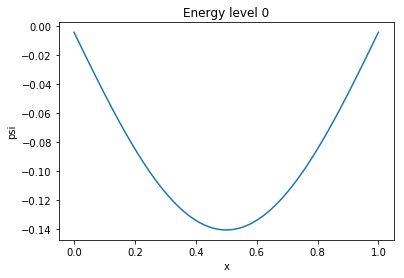

In [105]:
x = linspace(0,1,100)
plot(x,wavefunctions[:,0])
title("Energy level 0")
xlabel("x")
ylabel("psi")


Text(0,0.5,'psi')

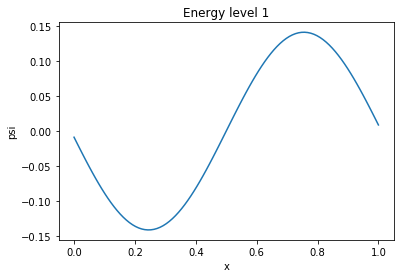

In [106]:
x = linspace(0,1,100)
plot(x,wavefunctions[:,1])
title("Energy level 1")
xlabel("x")
ylabel("psi")

Text(0,0.5,'psi')

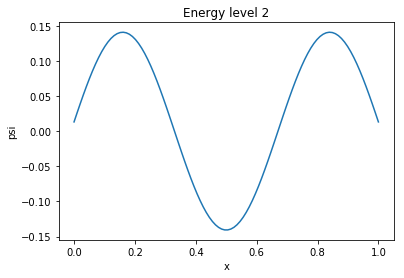

In [108]:
x = linspace(0,1,100)
plot(x,wavefunctions[:,2])
title("Energy level 2")
xlabel("x")
ylabel("psi")

Text(0,0.5,'psi')

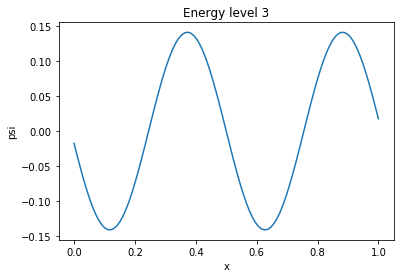

In [109]:
x = linspace(0,1,100)
plot(x,wavefunctions[:,3])
title("Energy level 3")
xlabel("x")
ylabel("psi")

Text(0,0.5,'psi')

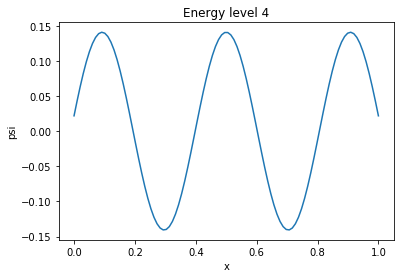

In [110]:
x = linspace(0,1,100)
plot(x,wavefunctions[:,4])
title("Energy level 4")
xlabel("x")
ylabel("psi")

2) Calculate the lowest 10 eigen-energies of a particle in a double-well potential $V(x)=0.5*(x^2-4)^2$.  Use units where $\hbar=m=1$.  Is there a separation of scales?  Plot the lowest 4 eigenstates.

<u>Give answer (program) here -- add more cells as necessary</u>

In [112]:
def double_well(x):
    return .5*(x**2 -4)**2 


In [119]:
d_well = HamiltonianMatrix(potentialfunction = double_well, minx = -5, maxx = 5, numpoints = 100, periodic = False)

In [121]:
eigsh(d_well, k=5, sigma=0, return_eigenvectors = False)

array([1.92722637, 1.92799869, 5.41940109, 5.47593834, 7.91091009])

In [123]:
energies,wavefunctions=eigsh(d_well,k=5, sigma=0,  return_eigenvectors=True)

Text(0,0.5,'psi')

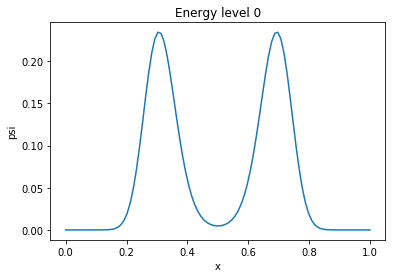

In [126]:
x = linspace(0,1,100)
plot(x,wavefunctions[:,0])
title("Energy level 0")
xlabel("x")
ylabel("psi")

Text(0,0.5,'psi')

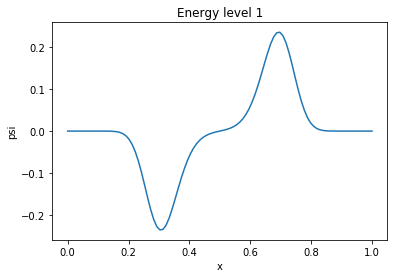

In [127]:
x = linspace(0,1,100)
plot(x,wavefunctions[:,1])
title("Energy level 1")
xlabel("x")
ylabel("psi")

Text(0,0.5,'psi')

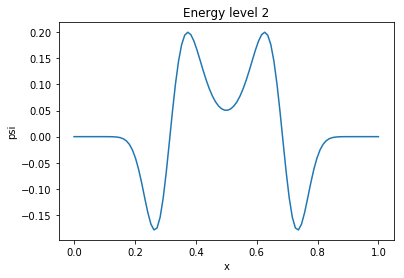

In [128]:
x = linspace(0,1,100)
plot(x,wavefunctions[:,2])
title("Energy level 2")
xlabel("x")
ylabel("psi")

Text(0,0.5,'psi')

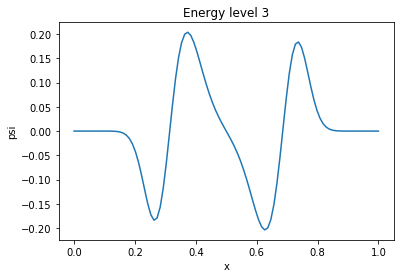

In [129]:
x = linspace(0,1,100)
plot(x,wavefunctions[:,3])
title("Energy level 3")
xlabel("x")
ylabel("psi")

Text(0,0.5,'psi')

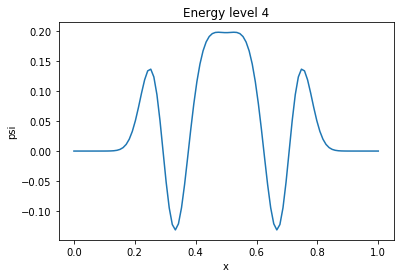

In [130]:
x = linspace(0,1,100)
plot(x,wavefunctions[:,4])
title("Energy level 4")
xlabel("x")
ylabel("psi")

3) Repeat with $V(x)=0.1∗(x^2−4)^2$.  

In [132]:
def double_well(x):
    return .1*(x**2 -4)**2 

In [133]:
d_well = HamiltonianMatrix(potentialfunction = double_well, minx = -5, maxx = 5, numpoints = 100, periodic = False)

In [134]:
eigsh(d_well, k=5, sigma=0, return_eigenvectors = False)

array([0.78267814, 0.85050527, 1.90525596, 2.54486174, 3.52072892])

In [135]:
energies,wavefunctions=eigsh(d_well,k=5, sigma=0,  return_eigenvectors=True)

Text(0,0.5,'psi')

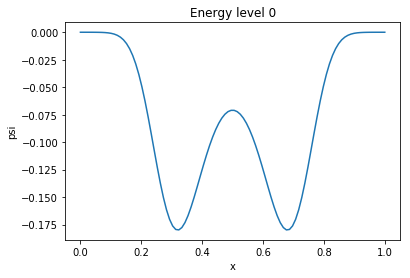

In [136]:
x = linspace(0,1,100)
plot(x,wavefunctions[:,0])
title("Energy level 0")
xlabel("x")
ylabel("psi")

Text(0,0.5,'psi')

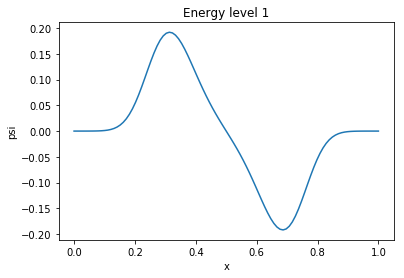

In [137]:
x = linspace(0,1,100)
plot(x,wavefunctions[:,1])
title("Energy level 1")
xlabel("x")
ylabel("psi")

Text(0,0.5,'psi')

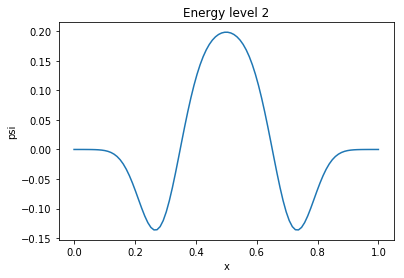

In [138]:
x = linspace(0,1,100)
plot(x,wavefunctions[:,2])
title("Energy level 2")
xlabel("x")
ylabel("psi")

Text(0,0.5,'psi')

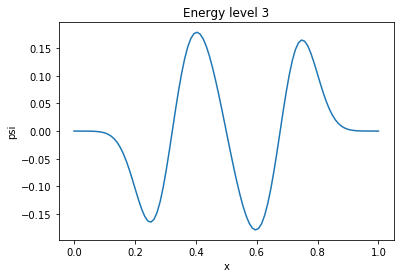

In [139]:
x = linspace(0,1,100)
plot(x,wavefunctions[:,3])
title("Energy level 3")
xlabel("x")
ylabel("psi")

Text(0,0.5,'psi')

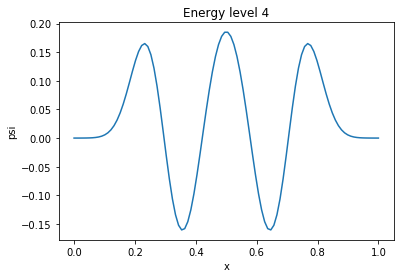

In [140]:
x = linspace(0,1,100)
plot(x,wavefunctions[:,4])
title("Energy level 4")
xlabel("x")
ylabel("psi")

Give answer (program) here -- add more cells as necessary

3) Numerically calculate the lowest 5 energy eigenvalues of a free particle confined in a box of length 1 with periodic boundary conditions.

<u>Give answer (program) here -- add more cells as necessary</u>

In [143]:
n = 1000
dx = 1./(n-1)
p_box = -SecondDerivMatrix(numpoints = n, dx=dx, periodic=True)
eigsh(p_box, k=5, sigma=0, return_eigenvectors = False)

array([-3.11652393e-12,  3.93991270e+01,  3.93998141e+01,  1.57595891e+02,
        1.57598898e+02])

4) In this case of a periodic box, are the eigenstates unique?  Why or why not?  

<u>The eigenstates are not unique, simply because you have to consider the positive and negative parity states
</u>